In [20]:
import sys
print(sys.executable)

c:\Python312\python.exe


In [21]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [22]:
# Load Dataset
df = pd.read_csv("gym_recommendation.csv")

In [23]:
# Table 1: Dataset Attributes and Description
print("Dataset Overview:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())
print("\nColumn Description:")
print(df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14589 entries, 0 to 14588
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              14589 non-null  int64  
 1   Sex             14589 non-null  object 
 2   Age             14589 non-null  int64  
 3   Height          14589 non-null  float64
 4   Weight          14589 non-null  float64
 5   Hypertension    14589 non-null  object 
 6   Diabetes        14589 non-null  object 
 7   BMI             14589 non-null  float64
 8   Level           14589 non-null  object 
 9   Fitness Goal    14589 non-null  object 
 10  Fitness Type    14589 non-null  object 
 11  Exercises       14589 non-null  object 
 12  Equipment       14589 non-null  object 
 13  Diet            14589 non-null  object 
 14  Recommendation  14589 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 1.7+ MB
None

First 5 Rows:
   ID   Sex  Age  Height 

In [24]:
# Define Input (X) and Output (y)
X = df[['Height', 'Weight', 'Sex', 'Hypertension', 'Diabetes', 'Fitness Goal']]  # Features
y = df[['Level', 'Fitness Type', 'Exercises', 'Diet', 'Recommendation']] # Outputs

In [25]:
# Convert Input Features (X) - One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Updated for sklearn v1.2+
X_encoded = encoder.fit_transform(X[['Sex', 'Hypertension', 'Diabetes', 'Fitness Goal']])
X_numeric = np.hstack((X[['Height', 'Weight']].values, X_encoded))

In [26]:
# Convert Output Labels (y) - Label Encoding
label_encoders = {}  # Store label encoders
y_encoded = pd.DataFrame()
for col in y.columns:
    le = LabelEncoder()
    y_encoded[col] = le.fit_transform(y[col])
    label_encoders[col] = le  # Store encoder

In [27]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y_encoded, test_size=0.2, random_state=42)


In [28]:
# Define Models
models = {
    "Random Forest": MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
    "Logistic Regression": MultiOutputClassifier(LogisticRegression(max_iter=500)),
    "SVM": MultiOutputClassifier(SVC()),
    "KNN": MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5)),
    "Gradient Boosting": MultiOutputClassifier(GradientBoostingClassifier(n_estimators=100, random_state=42)),
    "XGBoost": MultiOutputClassifier(XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
}

In [29]:
# Train and Evaluate Models
best_model = None
best_accuracy = 0
model_accuracies = {}

print("Evaluating Models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.mean([accuracy_score(y_test[col], y_pred[:, i]) for i, col in enumerate(y_test.columns)])
    model_accuracies[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name


Evaluating Models...
Random Forest Accuracy: 0.9603
Logistic Regression Accuracy: 0.9535
SVM Accuracy: 0.6526
KNN Accuracy: 0.9427
Gradient Boosting Accuracy: 0.9641
XGBoost Accuracy: 0.9649


In [30]:
# Table 2: Model Accuracy Comparison
accuracy_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])
print("\nModel Accuracy Comparison:")
print(accuracy_df)


Model Accuracy Comparison:
                 Model  Accuracy
0        Random Forest  0.960315
1  Logistic Regression  0.953461
2                  SVM  0.652570
3                  KNN  0.942700
4    Gradient Boosting  0.964085
5              XGBoost  0.964907


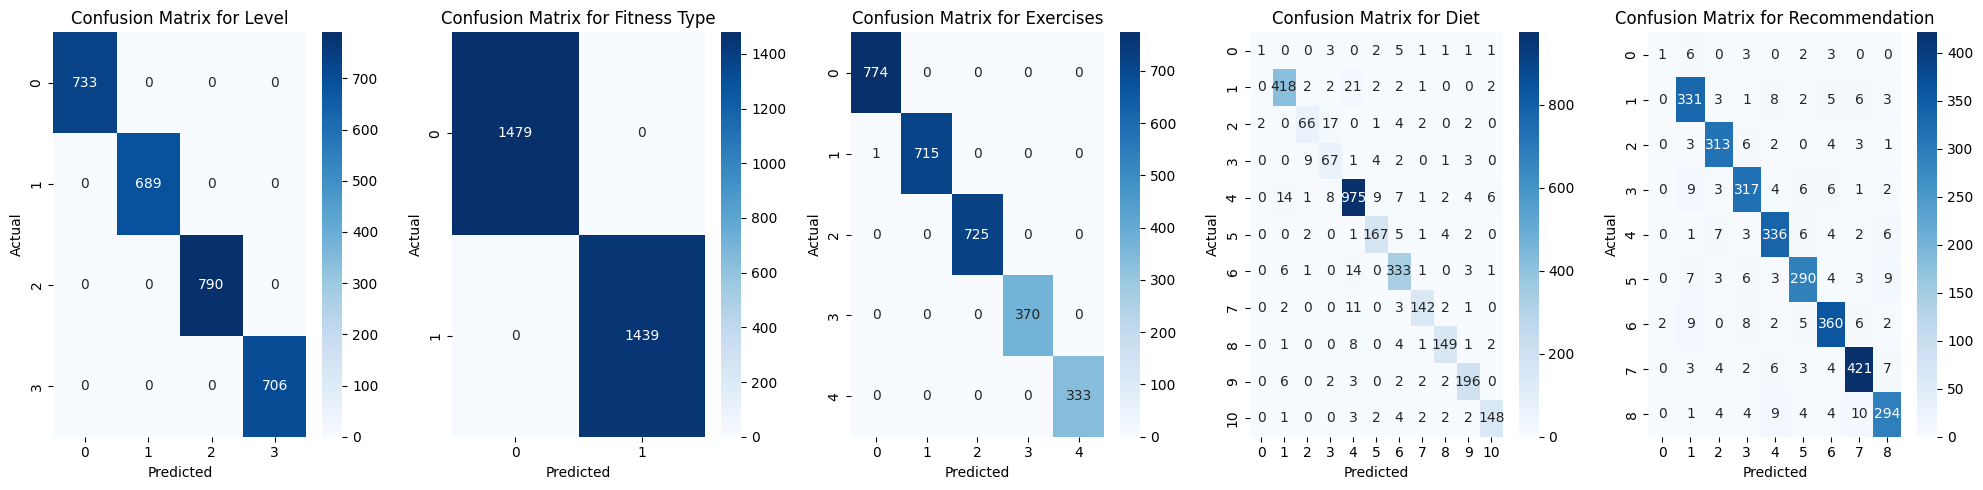

In [31]:
# Table 3: Confusion Matrix for Best Model
best_y_pred = best_model.predict(X_test)
fig, axes = plt.subplots(1, len(y_test.columns), figsize=(20, 5))
for i, col in enumerate(y_test.columns):
    cm = confusion_matrix(y_test[col], best_y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test[col]), yticklabels=np.unique(y_test[col]), ax=axes[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_title(f'Confusion Matrix for {col}')
plt.tight_layout()
plt.show()

In [32]:
# Table 4: Feature Importance Scores (For Tree-based Models)
if best_model_name in ["Random Forest", "Gradient Boosting", "XGBoost"]:
    feature_importance = best_model.estimators_[0].feature_importances_
    feature_names = ["Height", "Weight"] + encoder.get_feature_names_out().tolist()
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print("\nFeature Importance Scores:")
    print(importance_df)


Feature Importance Scores:
                    Feature  Importance
5  Fitness Goal_Weight Loss    0.868490
1                    Weight    0.103056
0                    Height    0.027542
4              Diabetes_Yes    0.000433
3          Hypertension_Yes    0.000354
2                  Sex_Male    0.000124


In [33]:
# Table 5: Performance Metrics for Each Model
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nPerformance Metrics for {name}:")
    for i, col in enumerate(y_test.columns):
        print(f"\nClassification Report for {col}:")
        print(classification_report(y_test[col], y_pred[:, i]))



Performance Metrics for Random Forest:

Classification Report for Level:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       733
           1       0.99      1.00      0.99       689
           2       1.00      0.99      0.99       790
           3       0.99      0.99      0.99       706

    accuracy                           0.99      2918
   macro avg       0.99      0.99      0.99      2918
weighted avg       0.99      0.99      0.99      2918


Classification Report for Fitness Type:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1479
           1       1.00      1.00      1.00      1439

    accuracy                           1.00      2918
   macro avg       1.00      1.00      1.00      2918
weighted avg       1.00      1.00      1.00      2918


Classification Report for Exercises:
              precision    recall  f1-score   support

           0       0.99      1

In [34]:
# Save Best Model & Encoders
with open("models.pkl", "wb") as model_file:
    pickle.dump((best_model, encoder, label_encoders), model_file)

print(f"Best Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")
print("Model trained and saved successfully!")

Best Model: XGBoost with Accuracy: 0.9649
Model trained and saved successfully!


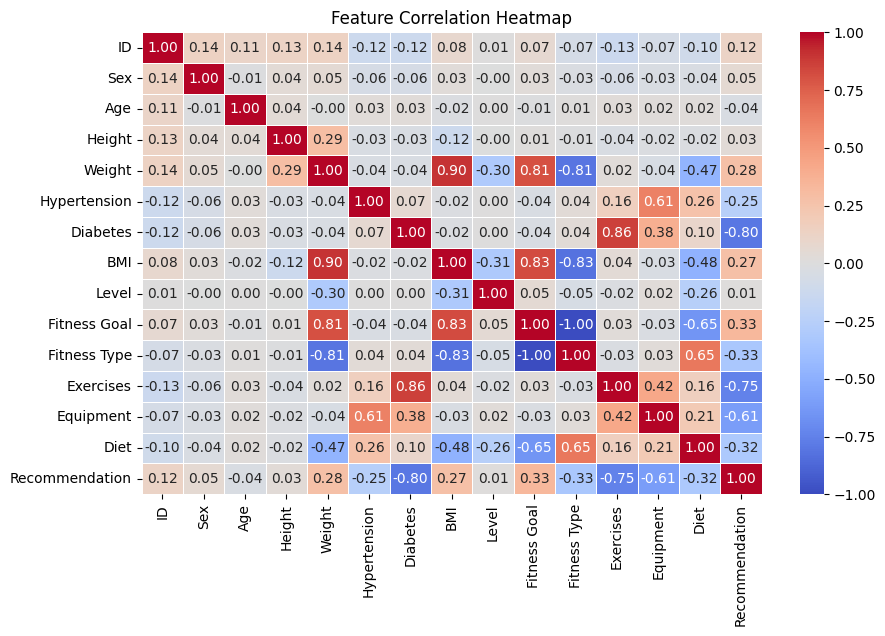

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load Dataset
df = pd.read_csv("gym_recommendation.csv")

# Identify categorical columns (excluding already numerical features)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Convert categorical variables into numerical representations using label encoding
df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes  # Encode categorical features

# Compute correlation matrix
corr_matrix = df_encoded.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()
